In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pywt
import pywt.data
import sys
import cv2
if '..' not in sys.path:
    sys.path.append('..')

from stego.coder.transform import blocking, dwt


In [2]:
original = pywt.data.camera()
cv2.imwrite("comp.jpg", original, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
img = cv2.imread("comp.jpg")
compressed, g, b = cv2.split(img)


In [3]:
def get_diffs(original, modified, transform, predicate):
    o_coeffs = transform.forward(original)
    m_coeffs = transform.forward(modified)

    diffs = []

    diffs.append(predicate(original[0], modified[0]))

    for o, m in zip(o_coeffs[1:], m_coeffs[1:]):
        level = []
        for i in range(3):
            level.append(predicate(o[i], m[i]))
        diffs.append(level)
    return diffs

def difference(n1, n2):
    return n1 - n2

def check_sign(matrix1, matrix2):
    # Replace any 0 elements with 1 to avoid division by 0
    matrix1 = np.where(matrix1 == 0, 1, matrix1)
    matrix2 = np.where(matrix2 == 0, 1, matrix2)
    
    # Check if the matrices have the same shape
    if matrix1.shape != matrix2.shape:
        raise ValueError("Input matrices have different shapes")
    
    # Multiply the matrices element-wise, then check if the result is positive
    result_matrix = np.where(np.multiply(matrix1, matrix2) > 0, 1, 0)
    return result_matrix


def plot_normal_distribution(data, ax):
    # Compute the mean and standard deviation of the data
    mean = np.mean(data)
    std = np.std(data)

    # Create a histogram of the data
    ax.hist(data, bins=50, density=True)

    # Add vertical lines to indicate one and two standard deviations from the mean
    ax.axvline(mean - std, linestyle='dashed', color='red')
    ax.axvline(mean + std, linestyle='dashed', color='red')
    ax.axvline(mean - 2 * std, linestyle='dashed', color='orange')
    ax.axvline(mean + 2 * std, linestyle='dashed', color='orange')

    # Add text labels next to the vertical lines
    ax.text(mean - std, 0, f"{mean - std:.1f}", rotation=90, color='red')
    ax.text(mean + std, 0, f"{mean + std:.1f}", rotation=90, color='red')
    ax.text(mean - 2 * std, 0, f"{mean - 2 * std:.1f}", rotation=90, color='orange')
    ax.text(mean + 2 * std, 0, f"{mean + 2 * std:.1f}", rotation=90, color='orange')

    ax.set_xlabel("Value difference")
    ax.set_ylabel("Probability Density")

In [4]:
img = cv2.imread("../images/1.jpg")
img_1, g, b = cv2.split(img)
img = cv2.imread("../images/1_comp.jpg")
img_1_comp, g, b = cv2.split(img)

## Does compression changes sign

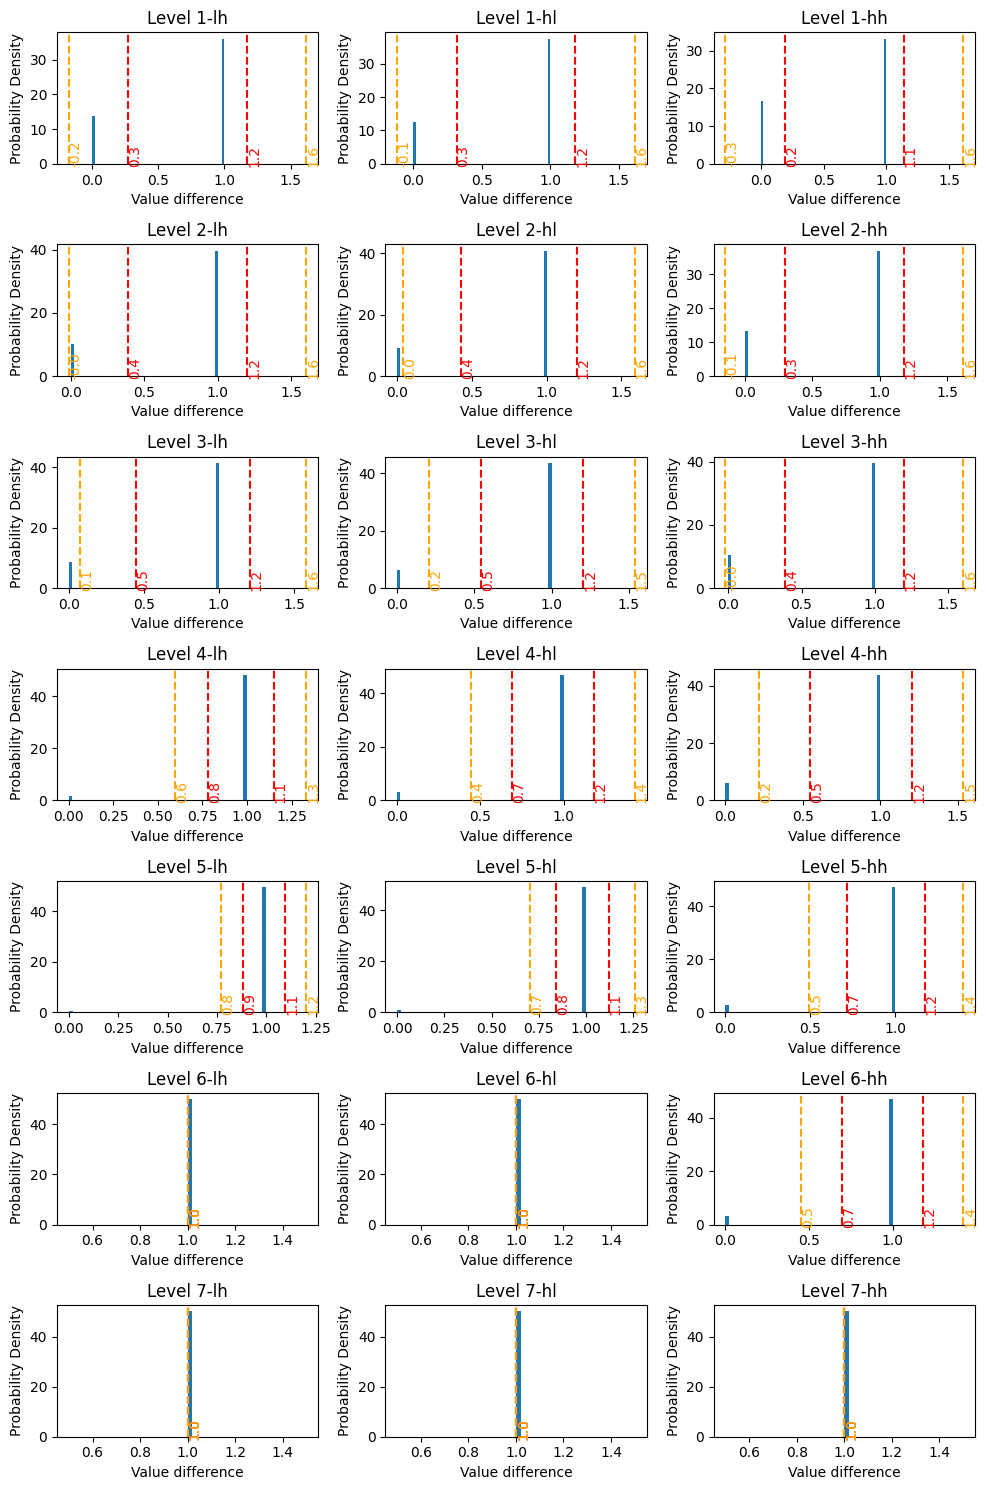

In [5]:

diffs = get_diffs(original, compressed, dwt.Dwt('haar', level=7), predicate=check_sign)
fig, axs = plt.subplots(len(diffs)-1, 3, figsize=(10, 15))

for i, level in enumerate(diffs[-1:0:-1]):
    for j, (band, band_name) in enumerate(zip(level,["lh", "hl", "hh"])):
        plot_normal_distribution(band.ravel(), axs[i, j])
        axs[i, j].set_title(f"Level {i+1}-{band_name}")
        

fig.tight_layout()
# Show the plot
plt.show()

## Difference in pixel values

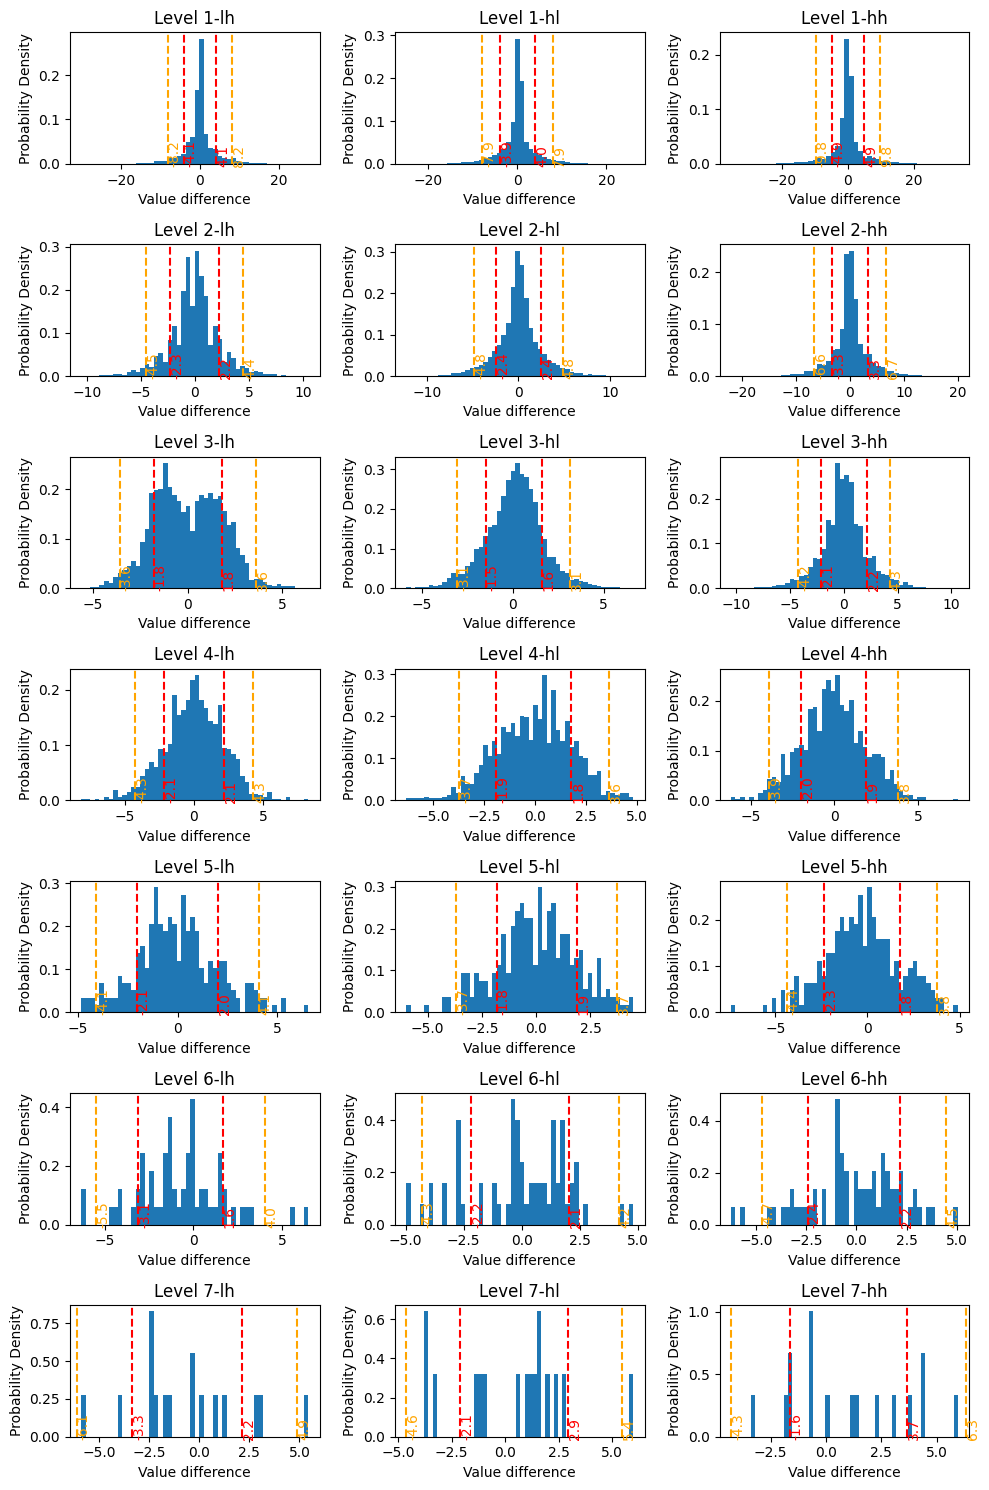

In [6]:

diffs = get_diffs(original, compressed, dwt.Dwt('haar', level=7), predicate=difference)
fig, axs = plt.subplots(len(diffs)-1, 3, figsize=(10, 15))

for i, level in enumerate(diffs[-1:0:-1]):
    for j, (band, band_name) in enumerate(zip(level,["lh", "hl", "hh"])):
        plot_normal_distribution(band.ravel(), axs[i, j])
        axs[i, j].set_title(f"Level {i+1}-{band_name}")
        

fig.tight_layout()
# Show the plot
plt.show()


## Ranges

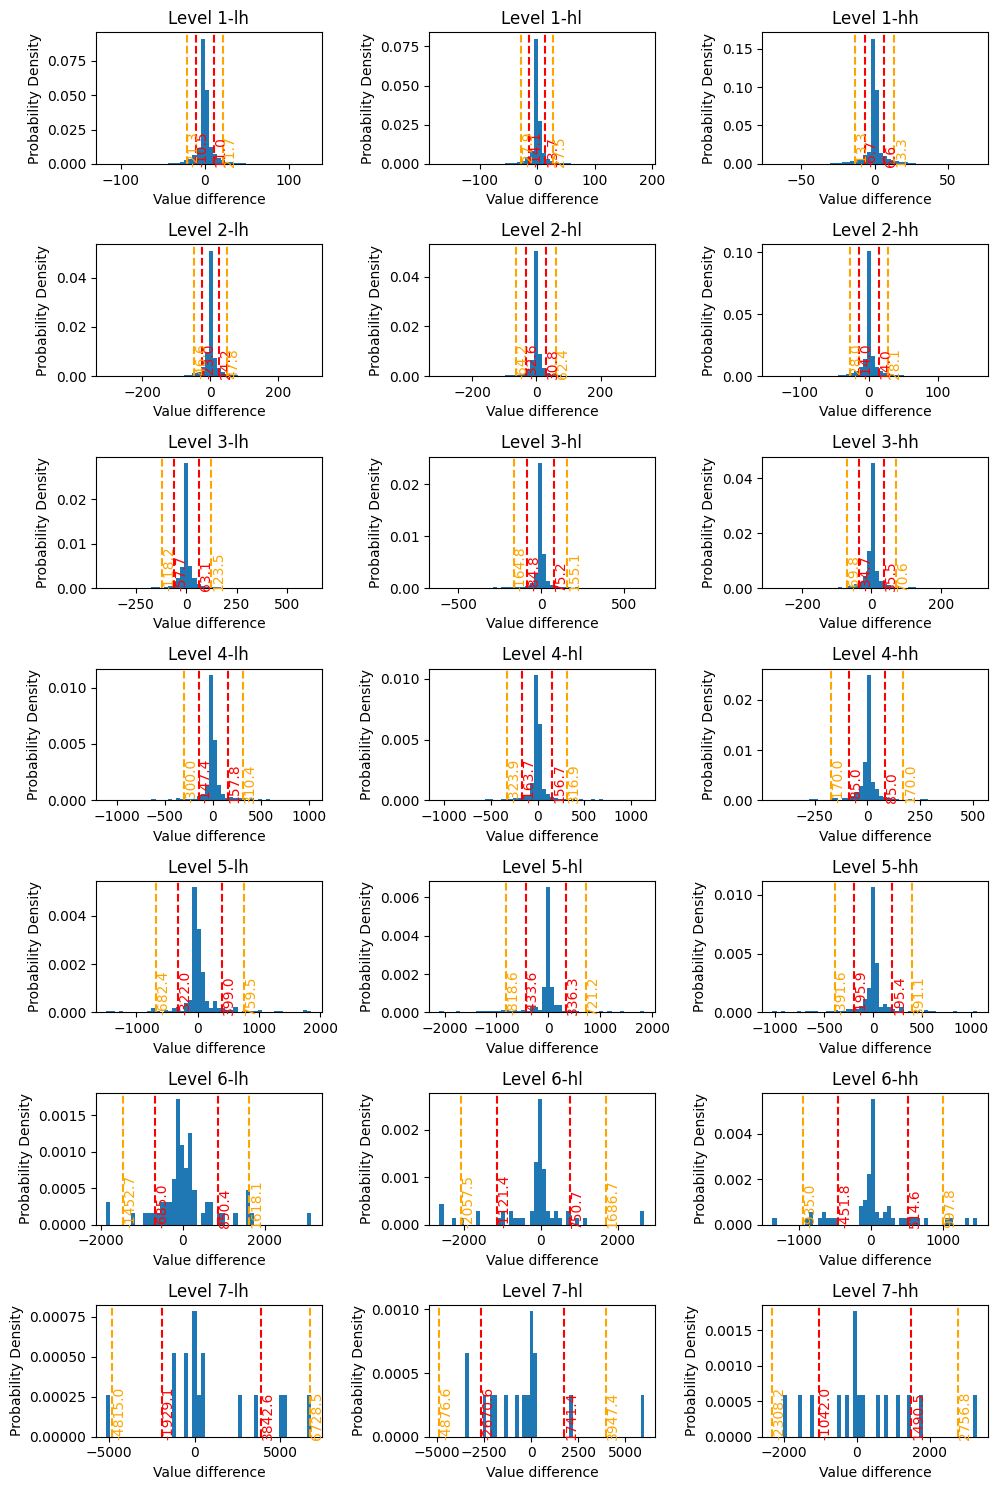

In [7]:
transform = dwt.Dwt('haar', level=7)

c = transform.forward(original)


fig, axs = plt.subplots(len(c)-1, 3, figsize=(10, 15))

for i, level in enumerate(c[-1:0:-1]):
    for j, (band, band_name) in enumerate(zip(level,["lh", "hl", "hh"])):
        plot_normal_distribution(band.ravel(), axs[i, j])
        axs[i, j].set_title(f"Level {i+1}-{band_name}")
        

fig.tight_layout()
# Show the plot
plt.show()

## Difference from std in 3x3 blocks

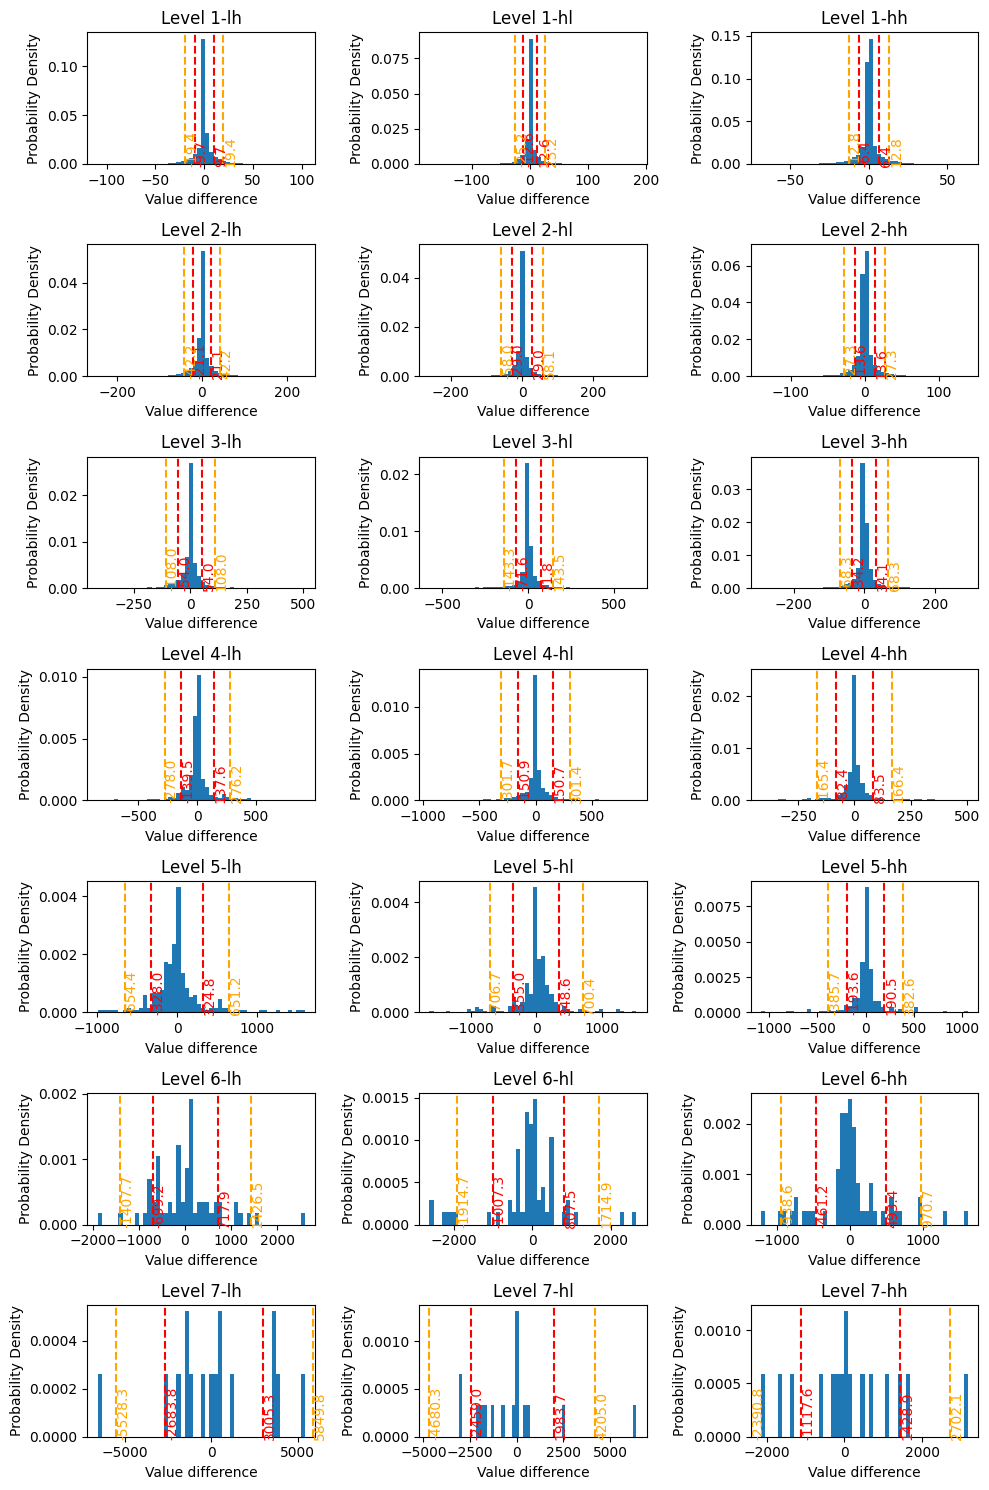

In [8]:
from stego.coder.transform.blocking import CropBlocker

transform = dwt.Dwt('haar', level=7)

c = transform.forward(original)


fig, axs = plt.subplots(len(c)-1, 3, figsize=(10, 15))

for i, level in enumerate(c[-1:0:-1]):
    for j, (band, band_name) in enumerate(zip(level,["lh", "hl", "hh"])):

        blocking = CropBlocker(band)
        blocks = blocking.divide(block_size=3)

        for m, row in enumerate(blocks):
            for n, block in enumerate(row):
                s = np.mean(block)
                blocks[m][n] = block - s

        band = blocking.stack(blocks)




        plot_normal_distribution(band.ravel(), axs[i, j])
        axs[i, j].set_title(f"Level {i+1}-{band_name}")
        

fig.tight_layout()
# Show the plot
plt.show()

The differance within the